In [3]:
# import libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
# Show plots in the notebook
%matplotlib inline

In [4]:
# problem1

In [5]:
# import data
data = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")

# check data
data

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [6]:
# 1.1
# slice the area needed (5N-5S, 170W-120W)
data = data.sel(lat=slice(-5,5), lon=slice(190, 240))

# check data
data

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 26, time: 684)
Coordinates:
  * lat      (lat) float32 -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [7]:
# check null values
data.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sst      int32 0

In [8]:
# calculate the mean of the data according to time
mean_time = data.mean(dim=['lat', 'lon'])

#check mean_time
mean_time

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time) float32 26.25 26.27 26.97 27.51 ... 26.1 25.82 25.72 25.76

In [9]:
# calculate the mean of the data according to month
mean_month = mean_time.groupby('time.month').mean()

# check result
mean_month

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 26.57 26.74 27.24 27.69 ... 26.74 26.72 26.69 26.61

In [10]:
# find the anomalies
anomalies =mean_time.groupby('time.month') - mean_month

# check result
anomalies

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 -0.3196 -0.4685 -0.2682 ... -0.8967 -0.9708 -0.8553

In [11]:
# 1.2
# calculate the rolling mean
mean_rolling = anomalies.rolling(time=3, center=True, min_periods=1).mean()

# check result
mean_rolling

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 -0.3941 -0.3521 -0.3079 ... -0.8358 -0.9076 -0.913

In [12]:
# transform to dataframe to plot, I am inspired by my roommate Zhouzhou
tf = mean_rolling.to_dataframe().reset_index()
anomalies_df = anomalies.to_dataframe().reset_index()

# check  result
tf

,time,month,sst
0,1960-01-15,1,-0.394051
1,1960-02-15,2,-0.352084
2,1960-03-15,3,-0.307880
3,1960-04-15,4,-0.210906
4,1960-05-15,5,-0.240752
...,...,...,...
679,2016-08-15,8,-0.618387
680,2016-09-15,9,-0.728148
681,2016-10-15,10,-0.835824
682,2016-11-15,11,-0.907570


In [13]:
# add rolling mean column and check result
anomalies_df['mean_rolloing'] = tf['sst']
anomalies_df

,time,month,sst,mean_rolloing
0,1960-01-15,1,-0.319580,-0.394051
1,1960-02-15,2,-0.468521,-0.352084
2,1960-03-15,3,-0.268152,-0.307880
3,1960-04-15,4,-0.186966,-0.210906
4,1960-05-15,5,-0.177599,-0.240752
...,...,...,...,...
679,2016-08-15,8,-0.647745,-0.618387
680,2016-09-15,9,-0.640022,-0.728148
681,2016-10-15,10,-0.896675,-0.835824
682,2016-11-15,11,-0.970774,-0.907570


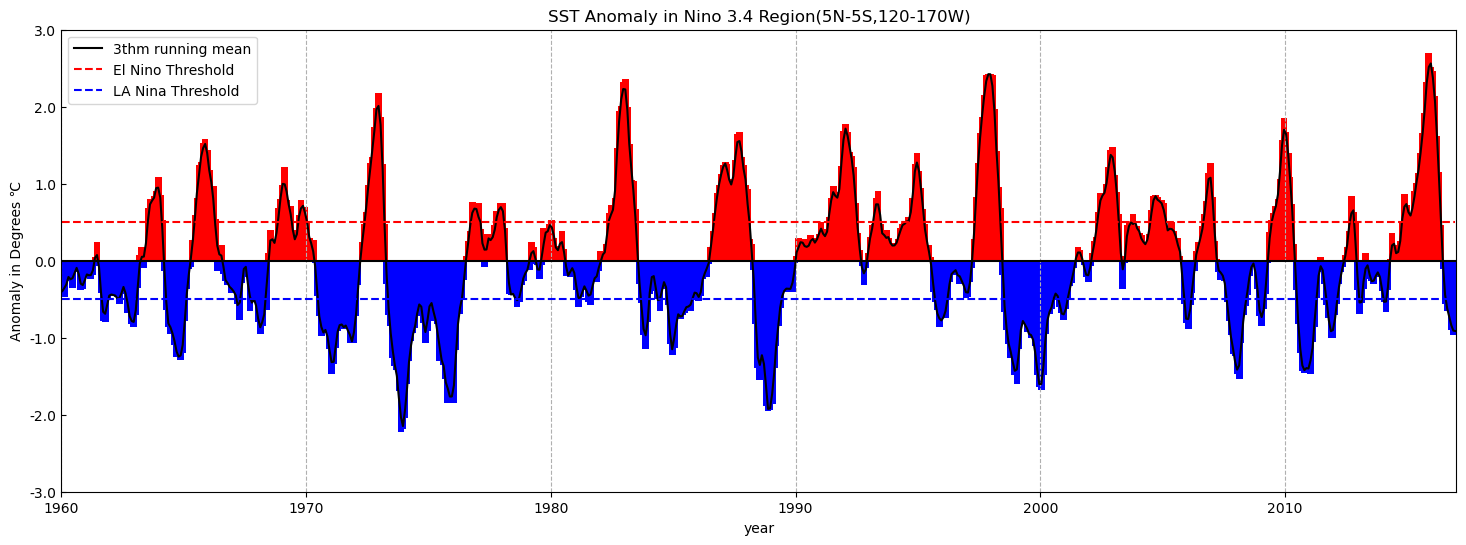

In [38]:
plt.figure(figsize=(18,6))

# adjust the color
colour = np.where(anomalies_df['sst']>0, 'red', 'blue')

# plot bar chart
#Zhouzhou inspired me to adjust the width
plt.bar(anomalies_df['time'], anomalies_df['sst'], width=100, color=colour)

#plot rolling_mean 
plt.plot(anomalies_df['time'],anomalies_df['mean_rolloing'], color='black',label='3thm running mean')

#plot the zero and threshold line 
plt.plot(anomalies_df['time'],np.zeros(684),color='black')
plt.plot(anomalies_df['time'],np.zeros(684)+0.5,color='red', linestyle='--',label='El Nino Threshold')
plt.plot(anomalies_df['time'],np.zeros(684)-0.5,color='blue', linestyle='--',label='LA Nina Threshold')

# adjust the label and ticks
# set label
plt.xlabel('year')
plt.ylabel('Anomaly in Degrees ℃')

#set ticks
y = [-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0]
plt.yticks(y,labels=y)
plt.xlim(datetime(1960,1,1),datetime(2016,12,31))
#plot title
plt.title('SST Anomaly in Nino 3.4 Region(5N-5S,120-170W)')

#plot grid
plt.grid(linestyle='--',axis='x')
plt.xlim()

#tick parameter
plt.tick_params(axis='y',left=True,direction='in',which='both')
plt.tick_params(axis='x',top=False,bottom=True,direction='out',which='both')
plt.legend()

In [15]:
# problem2

In [16]:
# import data
data = xr.open_dataset('CERES_EBAF-TOA_200003-201701.nc',engine='netcdf4')

# check data
data.isnull().sum()

<xarray.Dataset>
Dimensions:                      ()
Data variables: (12/14)
    toa_sw_all_mon               int32 0
    toa_lw_all_mon               int32 0
    toa_net_all_mon              int32 0
    toa_sw_clr_mon               int32 0
    toa_lw_clr_mon               int32 0
    toa_net_clr_mon              int32 0
    ...                           ...
    toa_cre_net_mon              int32 0
    solar_mon                    int32 0
    cldarea_total_daynight_mon   int32 0
    cldpress_total_daynight_mon  int32 12
    cldtemp_total_daynight_mon   int32 12
    cldtau_total_day_mon         int32 800856

In [17]:
# check data
data

<xarray.Dataset>
Dimensions:                      (lon: 360, time: 203, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 43.85 43.85 ... 0.049
    toa_lw_all_mon               (time, lat, lon) float32 139.6 139.6 ... 168.5
    toa_net_all_mon              (time, lat, lon) float32 -126.4 ... -168.6
    toa_sw_clr_mon               (time, lat, lon) float32 64.47 64.47 ... 0.006
    toa_lw_clr_mon               (time, lat, lon) float32 136.6 136.6 ... 175.8
    toa_net_clr_mon              (time, lat, lon) float32 -143.9 ... -175.9
    ...                           ...
    toa_cre_net_mon              (time, lat, lon) float32 17.57 17.57 ... 7.292
    solar_mon                    (time, lat, lon) float32 57.13 57.13 ... 0.0
    cldarea_total_daynight_mon   (time, lat, lon) float32 40.0 40.0 ... 80.71
    cldpress_total_daynight_mon  (time, lat, lon) float32 540.9 540.9 ... 737.5
    cldtemp_total_daynight_mon   (time, lat, lon) float32 228.5 228.5 ... 238.7
    cldtau_total_day_mon         (time, lat, lon) float32 6.038 6.038 ... nan
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

In [18]:
# calculate the mean according to time
mean_time = data.mean(dim='time')

# calculate and check the result
mean_time["result1"]=mean_time["solar_mon"]+mean_time['toa_sw_all_mon']+mean_time['toa_lw_all_mon']
mean_time["result2"]=mean_time["solar_mon"]-mean_time['toa_sw_all_mon']-mean_time['toa_lw_all_mon']
mean_time

<xarray.Dataset>
Dimensions:                      (lon: 360, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/16)
    toa_sw_all_mon               (lat, lon) float32 122.3 122.3 ... 104.4 104.4
    toa_lw_all_mon               (lat, lon) float32 141.1 141.1 ... 194.1 194.1
    toa_net_all_mon              (lat, lon) float32 -91.29 -91.29 ... -126.3
    toa_sw_clr_mon               (lat, lon) float32 119.9 119.9 ... 89.47 89.47
    toa_lw_clr_mon               (lat, lon) float32 140.2 140.2 ... 200.4 200.4
    toa_net_clr_mon              (lat, lon) float32 -88.03 -88.03 ... -117.6
    ...                           ...
    cldarea_total_daynight_mon   (lat, lon) float32 51.52 51.52 ... 78.93 78.93
    cldpress_total_daynight_mon  (lat, lon) float32 486.5 486.5 ... 766.9 766.9
    cldtemp_total_daynight_mon   (lat, lon) float32 225.2 225.2 ... 247.9 247.9
    cldtau_total_day_mon         (lat, lon) float32 4.158 4.158 ... 4.821 4.821
    result1                      (lat, lon) float32 435.4 435.4 ... 470.8 470.8
    result2                      (lat, lon) float32 -91.29 -91.29 ... -126.3

Text(0.5, 1.0, 'solar-sw-ls')

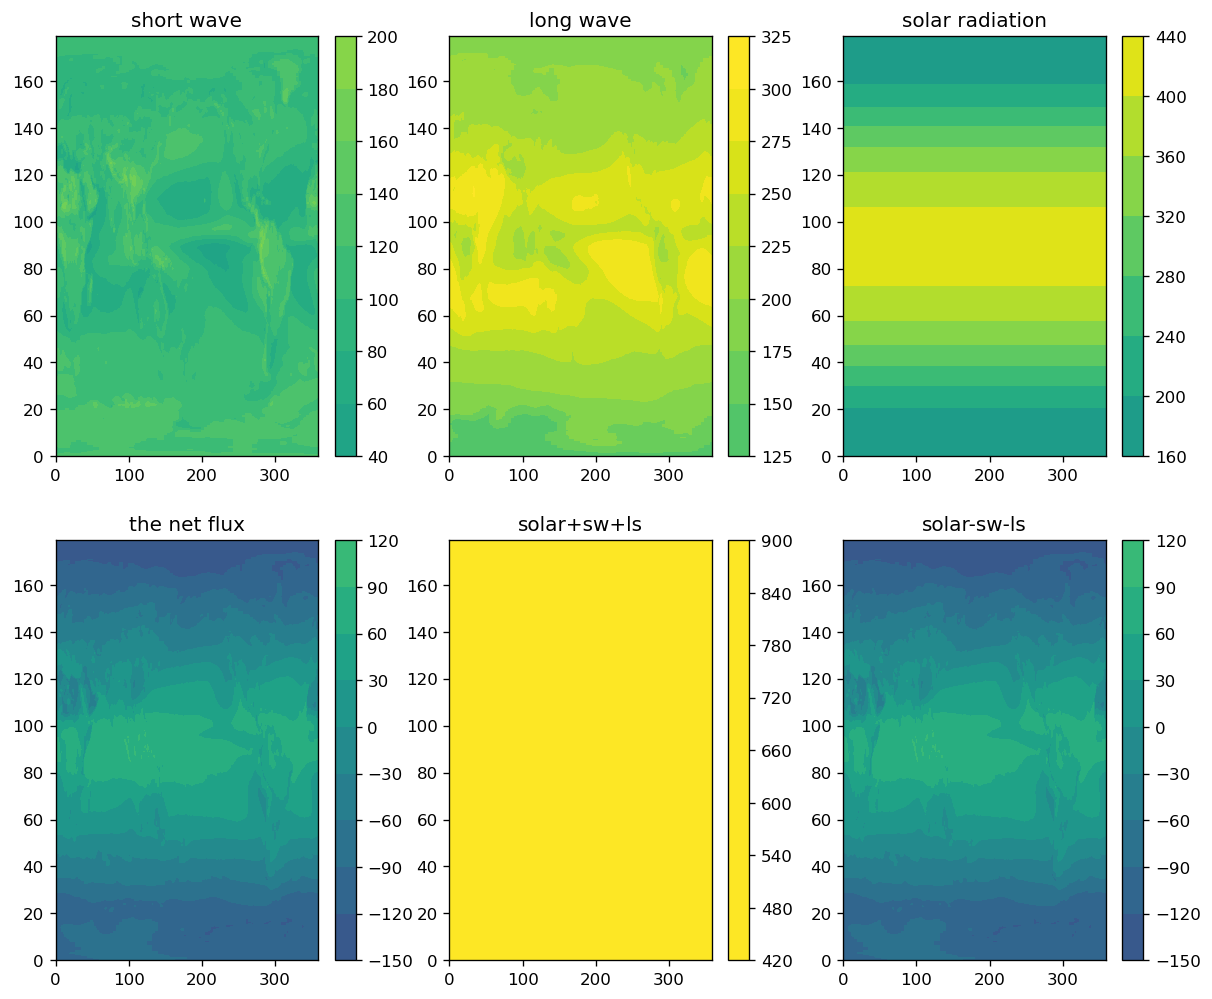

In [19]:
# 2.1
plt.figure(figsize=(12,10),dpi=120)

# plot the short wave
plt.subplot(2,3,1)
plt.contourf(mean_time['toa_sw_all_mon'])
plt.colorbar()
plt.clim(-300, 300)
plt.title('short wave')

# plot the long wave
plt.subplot(2,3,2)
plt.contourf(mean_time['toa_lw_all_mon'])
plt.colorbar()
plt.clim(-300, 300)
plt.title('long wave')

# plot the sun solar radiation
plt.subplot(2,3,3)
plt.contourf(mean_time["solar_mon"])
plt.colorbar()
plt.clim(-150, 450)
plt.title('solar radiation')

# plot the net flux
plt.subplot(2,3,4)
plt.contourf(mean_time["toa_net_all_mon"])
plt.colorbar()
plt.clim(-300, 300)
plt.title('the net flux')


# plot the calculate result "solar_mon"+'toa_sw_all_mon'+'toa_lw_all_mon'
plt.subplot(2,3,5)
plt.contourf(mean_time["result1"])
plt.colorbar()
plt.clim(-300, 300)
plt.title("solar+sw+ls")

# plot the calculate result "solar_mon"-('toa_sw_all_mon'+'toa_lw_all_mon')
plt.subplot(2,3,6)
plt.contourf(mean_time["result2"])
plt.colorbar()
plt.clim(-300, 300)
plt.title("solar-sw-ls")

In [20]:
# 2.2
# Calculate the TOA incoming solar
mean_time.solar_mon.sum()/360/180

<xarray.DataArray 'solar_mon' ()>
array(298.33052469)

In [21]:
# Calculate the TOA outgoing longwave
mean_time.toa_lw_all_mon.sum()/360/180

<xarray.DataArray 'toa_lw_all_mon' ()>
array(224.75516975)

In [22]:
# Calculate the TOA outgoing shortwave
mean_time.toa_sw_all_mon.sum()/360/180

<xarray.DataArray 'toa_sw_all_mon' ()>
array(102.3043287)

In [23]:
# 2.3
# Calculate and plot the total amount of net radiation in each 1-degree latitude band.
mean_lat=mean_time.sum(dim='lon')

#check the result
mean_lat

<xarray.Dataset>
Dimensions:                      (lat: 180)
Coordinates:
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/16)
    toa_sw_all_mon               (lat) float32 4.402e+04 4.367e+04 ... 3.76e+04
    toa_lw_all_mon               (lat) float32 5.079e+04 5.108e+04 ... 6.988e+04
    toa_net_all_mon              (lat) float32 -3.286e+04 ... -4.546e+04
    toa_sw_clr_mon               (lat) float32 4.323e+04 4.278e+04 ... 3.221e+04
    toa_lw_clr_mon               (lat) float32 5.046e+04 5.091e+04 ... 7.216e+04
    toa_net_clr_mon              (lat) float32 -3.174e+04 ... -4.234e+04
    ...                           ...
    cldarea_total_daynight_mon   (lat) float32 1.855e+04 1.849e+04 ... 2.841e+04
    cldpress_total_daynight_mon  (lat) float32 1.752e+05 1.697e+05 ... 2.761e+05
    cldtemp_total_daynight_mon   (lat) float32 8.108e+04 8.112e+04 ... 8.926e+04
    cldtau_total_day_mon         (lat) float32 1.497e+03 1.369e+03 ... 1.736e+03
    result1                      (lat) float32 1.568e+05 1.567e+05 ... 1.695e+05
    result2                      (lat) float32 -3.286e+04 ... -4.546e+04

Text(0.5, 1.0, 'Net total radiation in each 1-degree')

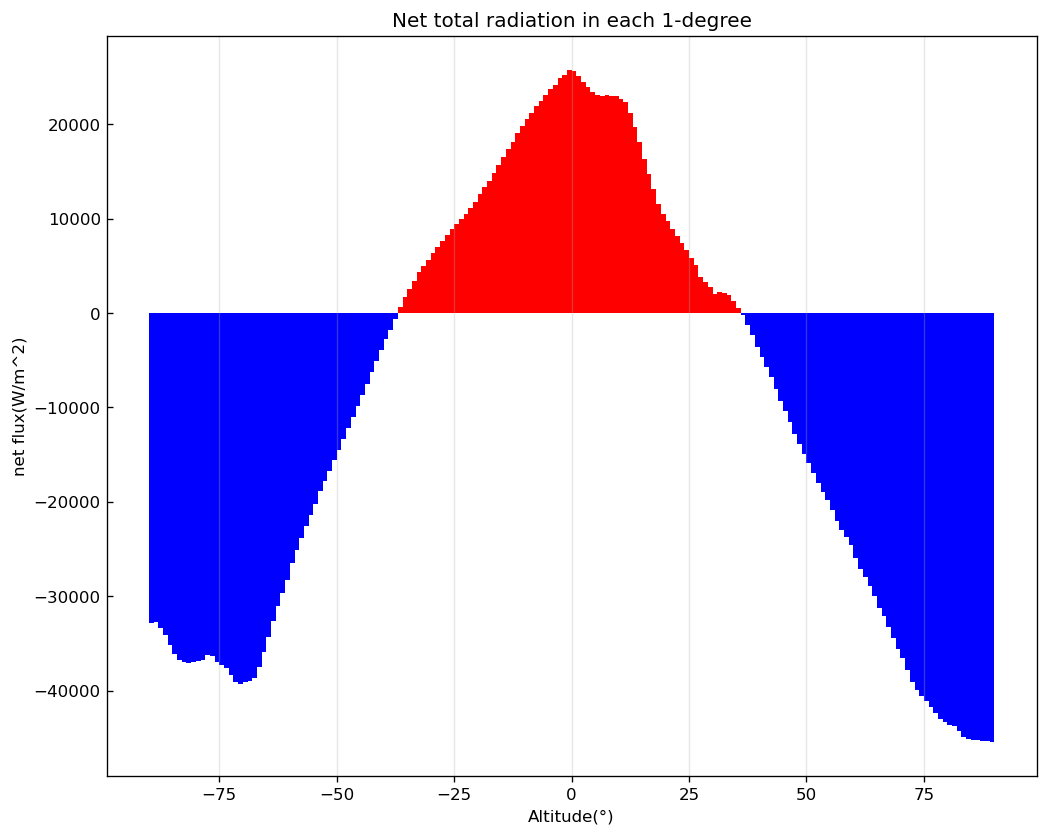

In [24]:

# plot the bar 
plt.figure(figsize=(10,8),dpi=120)

# set color
color = np.where(mean_lat['toa_net_all_mon']>0, 'red','blue')

# plot
plt.bar(mean_lat['lat'],mean_lat['toa_net_all_mon'],color=color,width=1)

# set grid
plt.grid(alpha=0.3,axis='x')

# set label
plt.xlabel('Altitude(°)')
plt.ylabel('net flux(W/m^2)')
plt.tick_params(axis='y',direction='in')
# set tltle
plt.title('Net total radiation in each 1-degree')

In [25]:
# 2.4
# select cloud area
mean_time.where(mean_time['cldarea_total_daynight_mon']>75,drop=True)
cloud_area = mean_time.where((mean_time['cldarea_total_daynight_mon']>75)|(mean_time['cldarea_total_daynight_mon']==75)|(mean_time['cldarea_total_daynight_mon']<25)|(mean_time['cldarea_total_daynight_mon']==25))

Text(0.5, 1.0, 'Short wave')

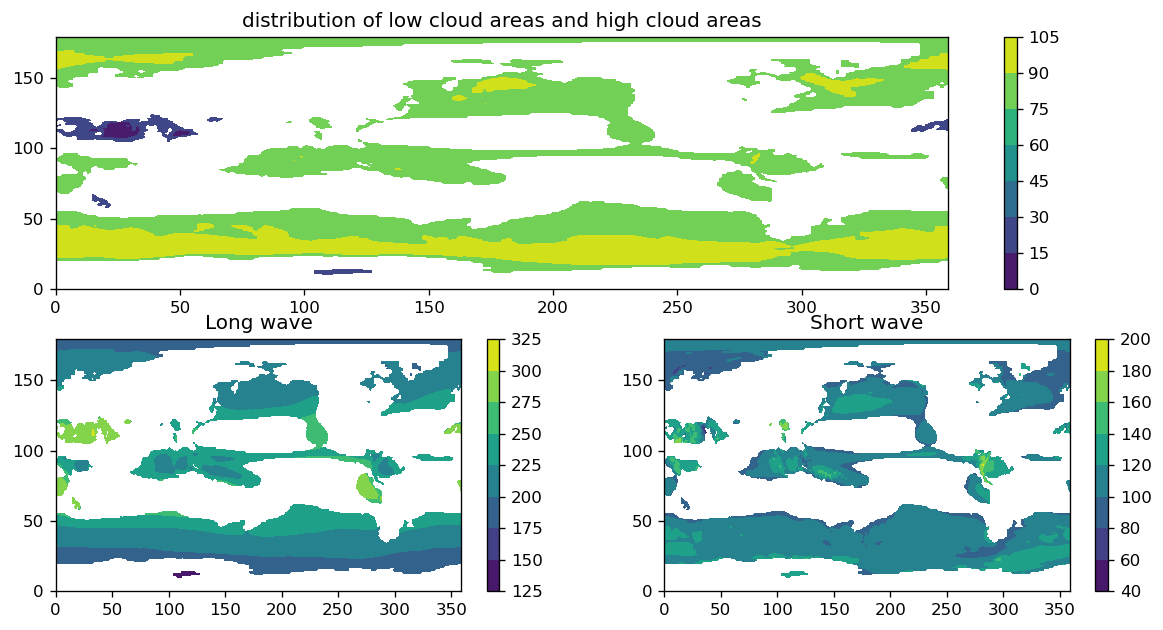

In [26]:
# plot
plt.figure(figsize=(12,6),dpi=120)
grid = plt.GridSpec(2, 2)

# plot the distribution of low cloud areas and high cloud areas
plt.subplot(grid[0:1, 0:2])
plt.contourf(cloud_area['cldarea_total_daynight_mon'])
plt.colorbar()
plt.title('distribution of low cloud areas and high cloud areas')

# plot the longwave
plt.subplot(grid[1:2, 0:1])
plt.contourf(cloud_area['toa_lw_all_mon'])
plt.colorbar()
plt.title('Long wave')

# plot the shortwave
plt.subplot(grid[1:2, 1:2])
plt.contourf(cloud_area['toa_sw_all_mon'])
plt.colorbar()
plt.title('Short wave')

In [33]:
# 2.5

# calculate the short and long wave
# low cloud area
area_lowcloud = mean_time.where((mean_time['cldarea_total_daynight_mon']<25)|(mean_time['cldarea_total_daynight_mon']==25))

#short wave
area_lowcloud.toa_sw_all_mon.mean()

<xarray.DataArray 'toa_sw_all_mon' ()>
array(122.65546, dtype=float32)

In [28]:
# long wave
area_lowcloud.toa_lw_all_mon.mean()

<xarray.DataArray 'toa_lw_all_mon' ()>
array(270.10367, dtype=float32)

In [34]:
# high cloud area
area_highcloud = mean_time.where((mean_time['cldarea_total_daynight_mon']>75)|(mean_time['cldarea_total_daynight_mon']==75))

# short wave
area_highcloud.toa_sw_all_mon.mean()

<xarray.DataArray 'toa_sw_all_mon' ()>
array(108.09777, dtype=float32)

In [35]:
# long wave
area_highcloud.toa_lw_all_mon.mean()

<xarray.DataArray 'toa_lw_all_mon' ()>
array(216.55675, dtype=float32)

In [30]:
# problem3